## Introduction

### In this project, a bank manager, concerned about the rising number of customers discontinuing their credit card services, seeks to predict which customers are likely to churn. The dataset comprises 10,000 customers, featuring 18 characteristics, with a churn rate of 16%. The Exploratory Data Analysis (EDA) reveals that attrited customers, those who ceased using services, are characterized by lower engagement, such as fewer transactions and reduced balances, alongside more frequent customer service contact and prolonged inactivity, possibly indicating dissatisfaction. Additionally, a slight gender disparity is observed, with a higher proportion of males in the non-attrited group. Utilizing a Random Forest Classifier, the project achieves notable predictive accuracy with an F1-score of 86% and a recall of 90%, effectively identifying 90% of attrited customers. The analysis identifies transaction amount and transaction frequency as the primary predictors of customer churn.

In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, make_scorer
from sklearn.ensemble import RandomForestClassifier
from scipy import stats


In [2]:
os.chdir('/Users/allenhardiman/Desktop/Python/Attrition')
df=pd.read_csv('BankChurners.csv') #Read Data
df.drop(df.columns[-2:], axis=1, inplace=True) #drop the naive bayes classifier variable 
df.drop('CLIENTNUM', axis=1, inplace=True) #This is unique client id, remove it

In [3]:
#check for missing values
for col in df.columns:
    if df[col].isnull().any():
        print(f"Column '{col}' has missing values")
    else:
        print(f"Column '{col}' has no missing values")

Column 'Attrition_Flag' has no missing values
Column 'Customer_Age' has no missing values
Column 'Gender' has no missing values
Column 'Dependent_count' has no missing values
Column 'Education_Level' has no missing values
Column 'Marital_Status' has no missing values
Column 'Income_Category' has no missing values
Column 'Card_Category' has no missing values
Column 'Months_on_book' has no missing values
Column 'Total_Relationship_Count' has no missing values
Column 'Months_Inactive_12_mon' has no missing values
Column 'Contacts_Count_12_mon' has no missing values
Column 'Credit_Limit' has no missing values
Column 'Total_Revolving_Bal' has no missing values
Column 'Avg_Open_To_Buy' has no missing values
Column 'Total_Amt_Chng_Q4_Q1' has no missing values
Column 'Total_Trans_Amt' has no missing values
Column 'Total_Trans_Ct' has no missing values
Column 'Total_Ct_Chng_Q4_Q1' has no missing values
Column 'Avg_Utilization_Ratio' has no missing values


### Get dummies for categortical variable

In [4]:
df=pd.get_dummies(df,columns=['Gender','Education_Level','Marital_Status','Income_Category','Card_Category'],drop_first=True)

In [5]:
df.loc[df['Attrition_Flag']=='Existing Customer', 'Attrited']=0 #Attrited=0 if attrition_flag is existing customer
df.loc[df['Attrition_Flag']=='Attrited Customer', 'Attrited']=1 #Attrited=1 if attrition_flag is attrited customer
df.drop('Attrition_Flag', axis=1, inplace=True)

## Look into correlation between attrition status and feature variables to see which variables has the highest correlation with attrition status

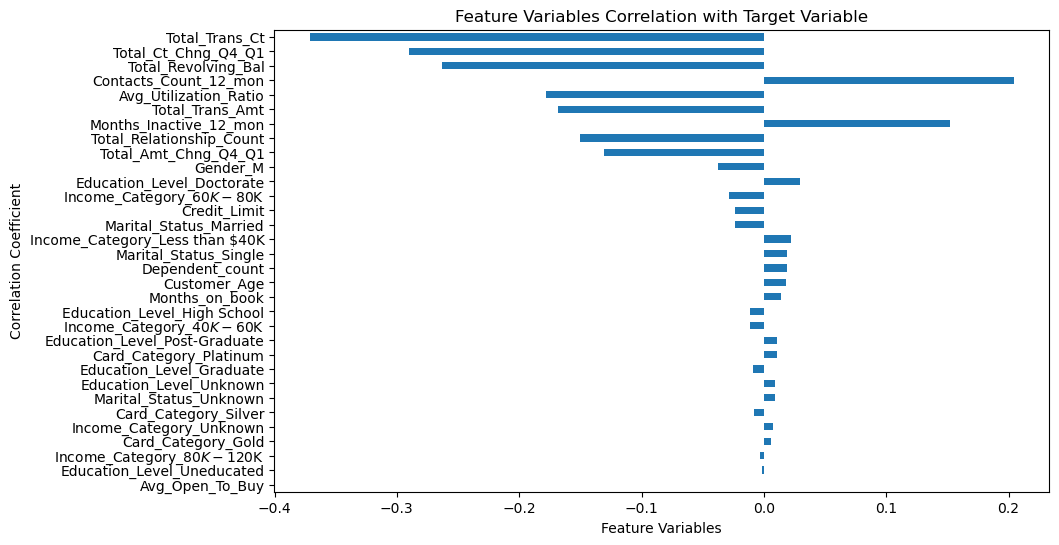

In [6]:
correlation=df.corrwith(df['Attrited'])
correlation=correlation.drop(labels=['Attrited'])

correlation=correlation.reindex(correlation.abs().sort_values(ascending=True).index)
plt.figure(figsize=(10, 6))
correlation.plot(kind='barh')
plt.title('Feature Variables Correlation with Target Variable')
plt.xlabel('Feature Variables')
plt.ylabel('Correlation Coefficient')
plt.show()

## Exploratory Data Analysis

Look at the difference in means among the 10 highest correlated features variables

In [7]:
top_10_features=['Total_Trans_Ct','Total_Ct_Chng_Q4_Q1','Total_Revolving_Bal','Contacts_Count_12_mon','Avg_Utilization_Ratio','Total_Trans_Amt','Months_Inactive_12_mon','Total_Relationship_Count','Total_Amt_Chng_Q4_Q1','Gender_M']

In [8]:
eda=df.groupby('Attrited')[top_10_features].mean().reset_index()

/var/folders/6p/6gsk4xxn53x8jdxck3k8w0k40000gn/T/ipykernel_62426/3897754222.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


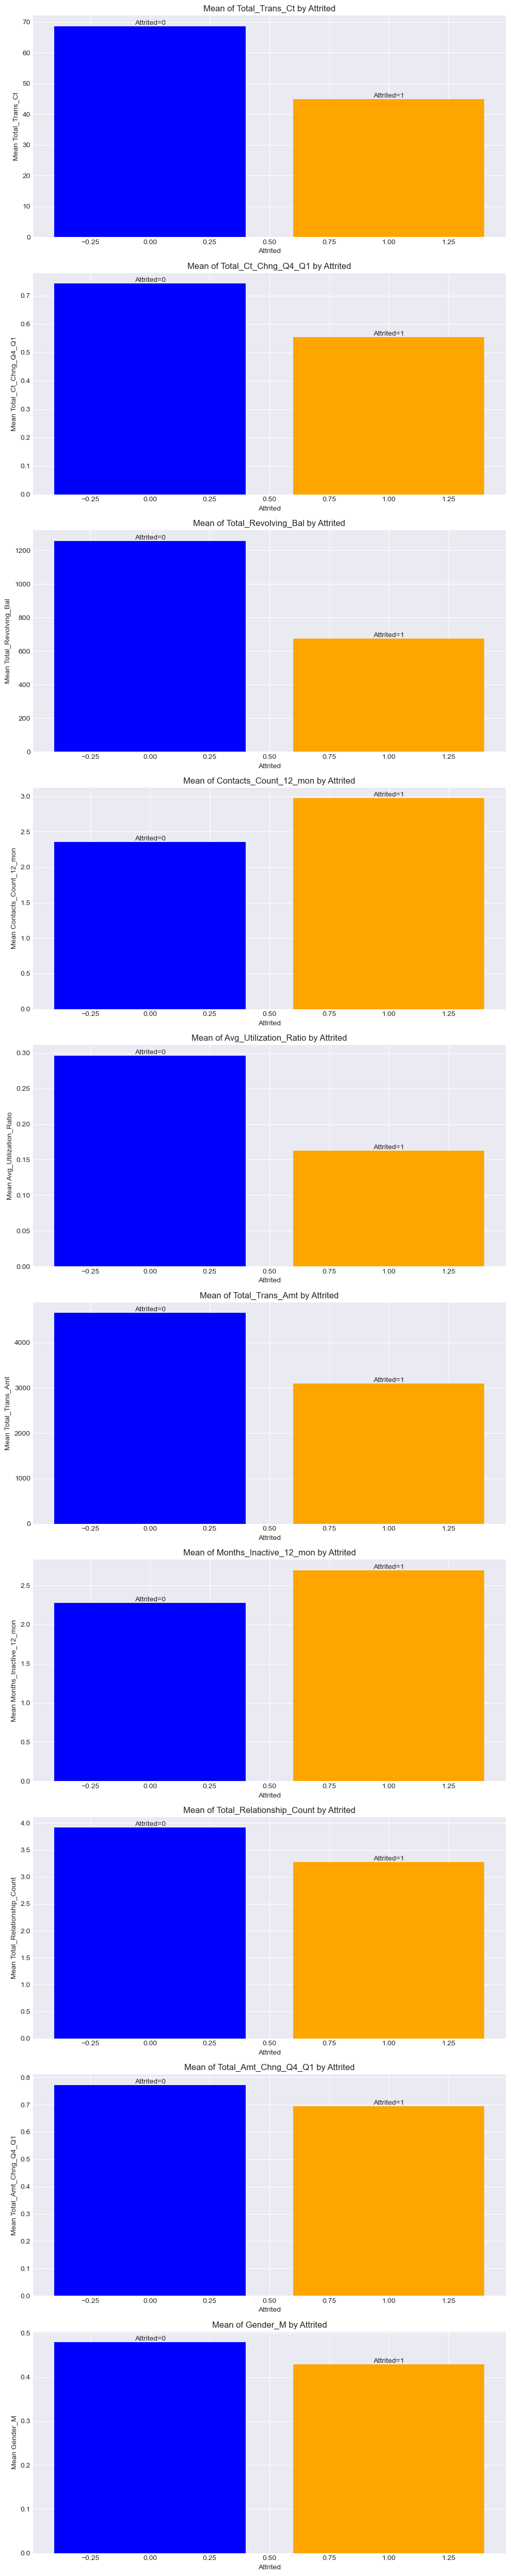

In [9]:
plt.style.use('seaborn-darkgrid')
num_vars = len(eda.columns) - 1  # Excluding 'Attrited'
fig, ax = plt.subplots(num_vars, 1, figsize=(10, 5 * num_vars))

for i, col in enumerate(eda.columns[1:]):  # Skipping 'Attrited'
    bars = ax[i].bar(eda['Attrited'], eda[col], color=['blue', 'orange'])
    ax[i].set_title(f'Mean of {col} by Attrited')
    ax[i].set_xlabel('Attrited')
    ax[i].set_ylabel(f'Mean {col}')

    # Annotate each bar
    for bar in bars:
        label = "Attrited=0" if bar.get_x() < 0.5 else "Attrited=1"
        ax[i].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), label, 
                   ha='center', va='bottom')

plt.tight_layout()
plt.show()

### There seems to be large differences across some variables , but let's check with t-tests to see if the difference is statistically significant

In [10]:
df_top10=df[['Attrited','Total_Trans_Ct','Total_Ct_Chng_Q4_Q1','Total_Revolving_Bal','Contacts_Count_12_mon','Avg_Utilization_Ratio','Total_Trans_Amt','Months_Inactive_12_mon','Total_Relationship_Count','Total_Amt_Chng_Q4_Q1','Gender_M']]

#list to store results
t_test_results = []

for col in df_top10.columns[1:] : #Skipping 'Attrited'
    group1 = df_top10[df_top10['Attrited'] == 0][col]
    group2 = df_top10[df_top10['Attrited'] == 1][col]
    t_stat, p_val = stats.ttest_ind(group1, group2, nan_policy='omit')  # 'omit' to ignore NaNs
    t_test_results.append({'Variable': col, 'T-Statistic': t_stat, 'P-Value': p_val})

t_test_results_df=pd.DataFrame(t_test_results)

# Add a boolean column for significant results
t_test_results_df['Significant'] = t_test_results_df['P-Value'] < 0.05


In [11]:
t_test_results_df

,Variable,T-Statistic,P-Value,Significant
0,Total_Trans_Ct,40.250735,0.000000e+00,True
1,Total_Ct_Chng_Q4_Q1,30.497187,1.647725e-195,True
2,Total_Revolving_Bal,27.435423,6.630148e-160,True
3,Contacts_Count_12_mon,-21.020658,4.697490e-96,True
4,Avg_Utilization_Ratio,18.244911,3.357689e-73,True
5,Total_Trans_Amt,17.211267,1.857439e-65,True
6,Months_Inactive_12_mon,-15.521288,1.032664e-53,True
7,Total_Relationship_Count,15.266725,4.829281e-52,True
8,Total_Amt_Chng_Q4_Q1,13.302693,4.836643e-40,True
9,Gender_M,3.753000,1.757076e-04,True


/var/folders/6p/6gsk4xxn53x8jdxck3k8w0k40000gn/T/ipykernel_62426/3695181117.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


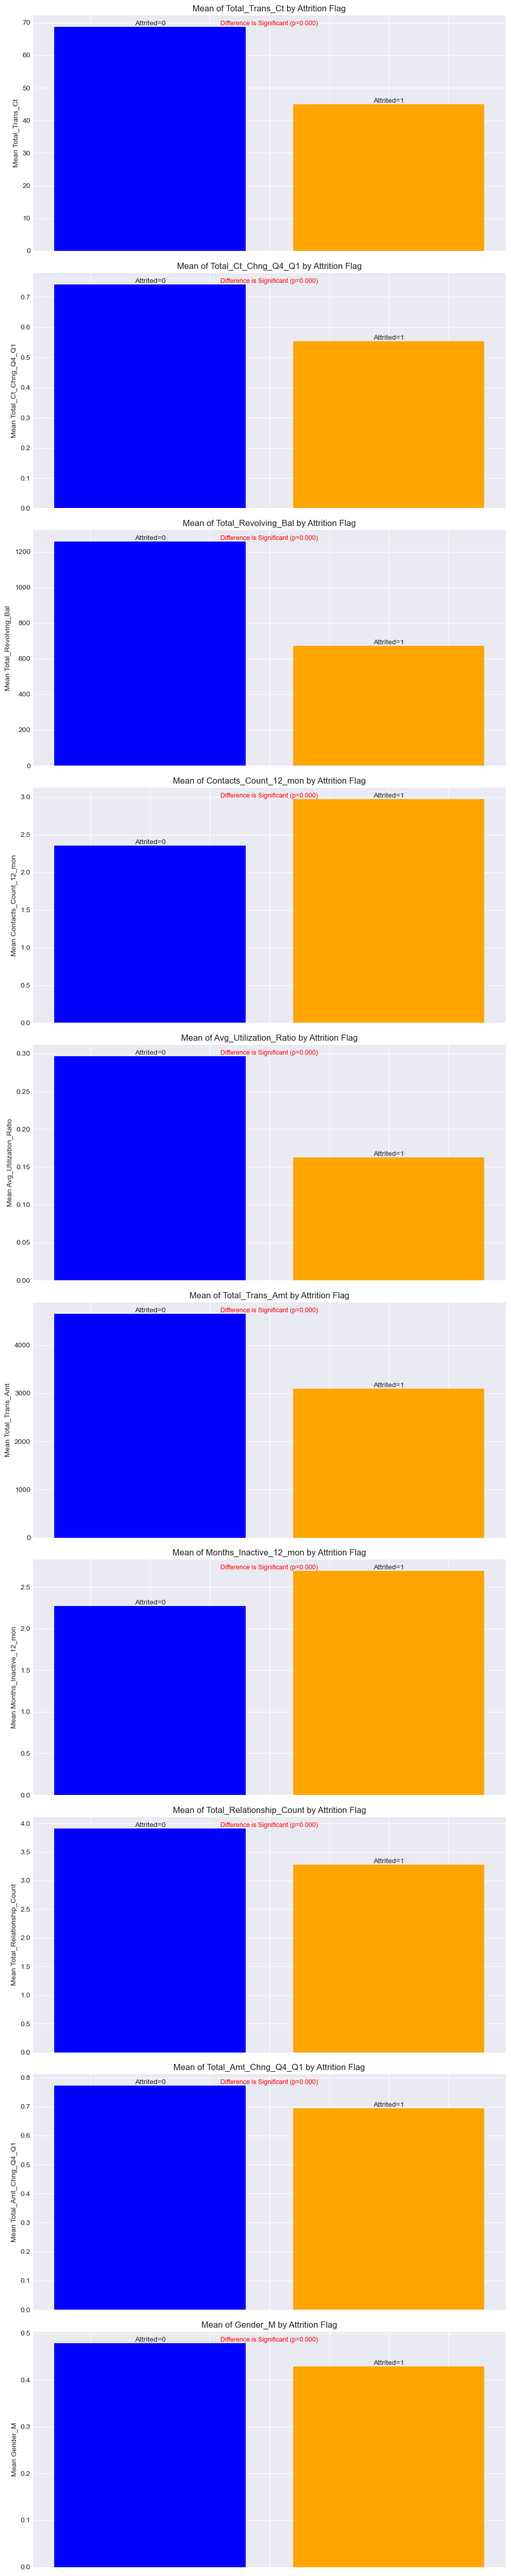

In [12]:
plt.style.use('seaborn-darkgrid')
num_vars=len(eda.columns) - 1 #Excluding 'Attrited'
fig, ax =plt.subplots(num_vars, 1, figsize=(10, 5* num_vars))

# Loop through the variables and create a bar chart for each

for i, col in enumerate(eda.columns[1:]):  # Skipping 'Attrited'
    bars = ax[i].bar(eda['Attrited'], eda[col], color=['blue','orange'])
    ax[i].set_title(f'Mean of {col} by Attrition Flag')
    #ax[i].set_xlabel('Attrited')
    ax[i].set_ylabel(f'Mean {col}')

    ax[i].set_xticklabels([])

        # Annotate each bar
    for bar in bars:
        height = bar.get_height()
        label_x_pos = bar.get_x() + bar.get_width() / 2
        ax[i].text(label_x_pos, height, 'Attrited=0' if bar.get_x() < 0.5 else 'Attrited=1', 
                   ha='center', va='bottom')

        # Check if the difference is significant and annotate
    p_value = t_test_results_df[t_test_results_df['Variable'] == col]['P-Value'].values[0]
    significant = "Significant" if p_value < 0.05 else "Not Significant"
    ax[i].text(0.5, max(eda[col]), f"Difference is {significant} (p={p_value:.3f})", 
               ha='center', va='bottom', color='red', fontsize=9)

plt.tight_layout()
plt.show()

### What this EDA tells us:
-Attrited customers (those who left or stopped using services) generally show lower engagement with the bank's services, as indicated by lower transaction counts, transaction amounts, revolving balances, and changes in transaction amounts.

-Attrited customers contacted customer service more frequently and were inactive for longer periods, which could indicate dissatisfaction or disengagement.

-The gender distribution shows a slightly higher proportion of males in the non-attrited group compared to the attrited group

#### All the differences are statistically significant

## Now let's do Random Forest Classifier to predict customers who will churn. For attrition, we would want to have a high recall score because we'd want to maximize the proportion of attrition that was identified correctly by the total number of attrition

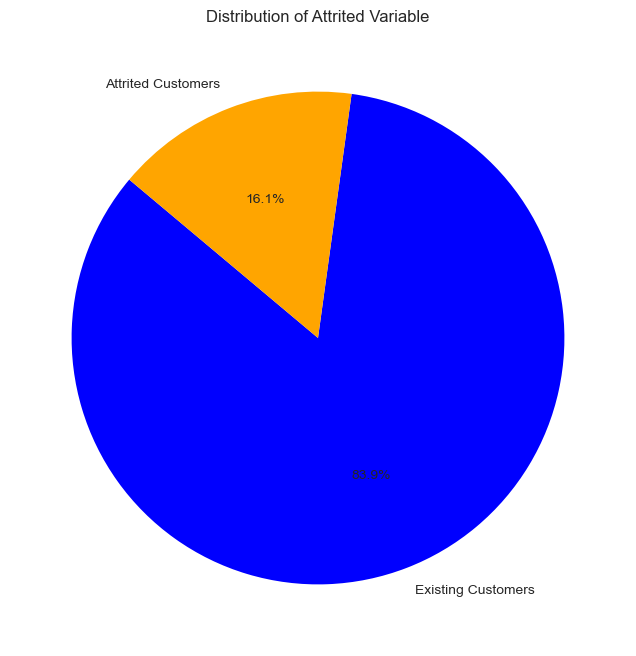

In [13]:
attrited_counts=df['Attrited'].value_counts()

labels = ['Existing Customers' if index == 0.0 else 'Attrited Customers' for index in attrited_counts.index]
plt.figure(figsize=(8,8))
plt.pie(attrited_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=['blue','orange'])
plt.title('Distribution of Attrited Variable')
plt.show()

#### We have class imbalanced here, where ~16% of customers attrited while 84% did not. This means accuracy may not be a good measure for model performance. For attrition, we would want to prioritize recall as a measure of performance because we'd want to maximize the proportion of attrition that was identified correctly by the total number of attrition

In [14]:
X=df.drop('Attrited', axis=1)
y=df['Attrited']

#### Split the data

In [15]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
model=RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred=model.predict(X_test)

In [17]:
print(classification_report(y_test,y_pred))

f1=f1_score(y_test,y_pred, average='binary')

print(f"F-1 Score is {f1}")

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97      1699
         1.0       0.94      0.76      0.84       327

    accuracy                           0.95      2026
   macro avg       0.95      0.87      0.90      2026
weighted avg       0.95      0.95      0.95      2026

F-1 Score is 0.8358714043993232


#### Random Forest model generates a recall score of 76% and an F-1 score of 83%. Next, I'll work on improving the Random Forest model to make it more accurate using RandomizedSearchCV

In [18]:

grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [4, 6, 8, 10, 12],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample', None]
}

rf = RandomForestClassifier(random_state=42)

scorer=make_scorer(f1_score)

# Instantiate the grid search model
random_search = RandomizedSearchCV(rf, param_distributions=grid, 
                           cv=5, random_state=42, n_iter=5, scoring=scorer)

# Fit the grid search to the data
random_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters:", random_search.best_params_)

# define the best model

best_rf = random_search.best_estimator_

#Use to predict

y_pred_best=best_rf.predict(X_test)

Best parameters: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10, 'class_weight': 'balanced_subsample', 'bootstrap': False}


In [19]:
#Print model performance
print(classification_report(y_test,y_pred_best))

f1_best=f1_score(y_test,y_pred_best, average='binary')

print(f"F-1 Score of the improved model is {f1_best}")

              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97      1699
         1.0       0.83      0.90      0.87       327

    accuracy                           0.95      2026
   macro avg       0.91      0.93      0.92      2026
weighted avg       0.96      0.95      0.96      2026

F-1 Score of the improved model is 0.8651026392961876


In [20]:
recall=recall_score(y_test,y_pred)
recall_best=recall_score(y_test,y_pred_best)
print(f"Recall score after hyperparameter tuning is {recall_best}, which is an improvement on the original model with a recall score of {recall}")

Recall score after hyperparameter tuning is 0.9021406727828746, which is an improvement on the original model with a recall score of 0.7553516819571865


### Models Predictions Conclusion
#### Random Forest Classifier demonstrates outstanding predictive performance, achieving an F1-score of 86% and a recall score of 90%. The recall score indicates
#### that among all attrited customers, the model identified 90% of them correctly

## ROC Curve for Final Model

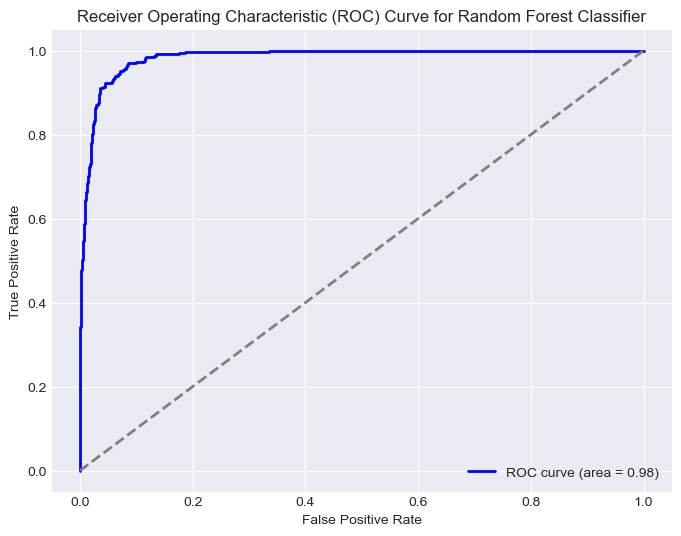

In [21]:
y_prob=best_rf.predict_proba(X_test)[:, 1] #Predict probabilities
auc=roc_auc_score(y_test, y_prob) #get auc

fpr, tpr, thresholds= roc_curve(y_test, y_prob)

#Draw ROC Curve

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Random Forest Classifier')
plt.legend(loc="lower right")
plt.show()

                           feature  importance
11                  Total_Trans_Ct    0.232653
10                 Total_Trans_Amt    0.213983
7              Total_Revolving_Bal    0.115211
12             Total_Ct_Chng_Q4_Q1    0.102436
13           Avg_Utilization_Ratio    0.069041
9             Total_Amt_Chng_Q4_Q1    0.056483
3         Total_Relationship_Count    0.043182
4           Months_Inactive_12_mon    0.030022
5            Contacts_Count_12_mon    0.024075
6                     Credit_Limit    0.023933
8                  Avg_Open_To_Buy    0.023344
0                     Customer_Age    0.018486
2                   Months_on_book    0.014363
14                        Gender_M    0.008140
1                  Dependent_count    0.005471
21          Marital_Status_Married    0.003028
22           Marital_Status_Single    0.002091
26    Income_Category_$80K - $120K    0.001682
27  Income_Category_Less than $40K    0.001534
16        Education_Level_Graduate    0.001320
25     Income

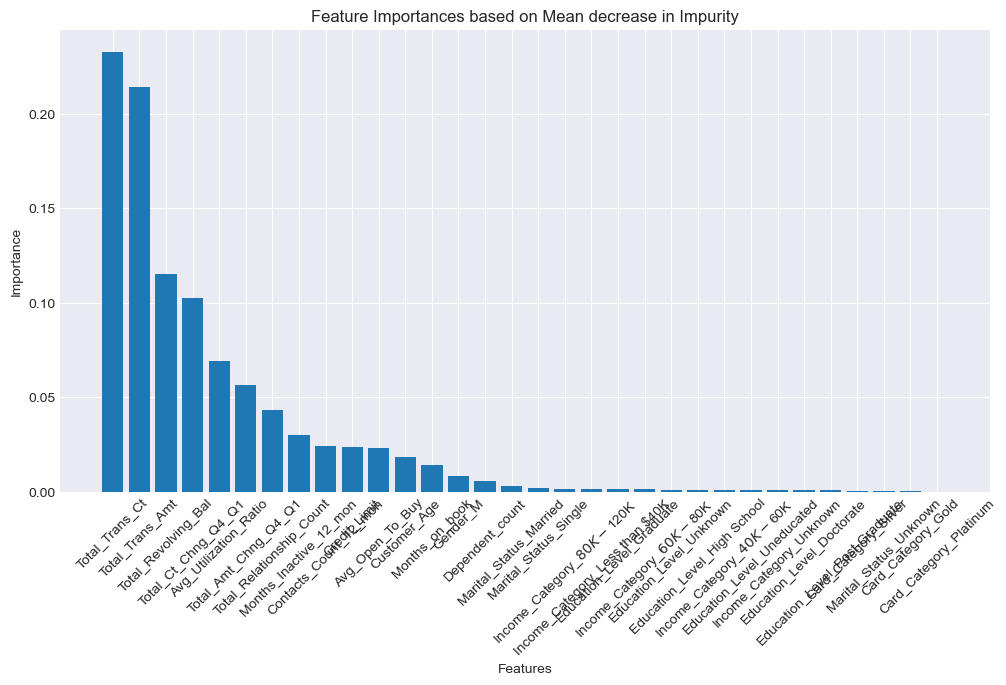

In [22]:
# Get feature importances
importances = best_rf.feature_importances_

# Convert to a DataFrame for easy handling
feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': importances})

# Sort the features by importance
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Display the feature importances
print(feature_importances)

# Visualization (optional)
plt.figure(figsize=(12, 6))
plt.title('Feature Importances based on Mean decrease in Impurity')
plt.bar(feature_importances['feature'], feature_importances['importance'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.show()

### This tells us that transaction amount and numbers of transactions are the biggest predictor in whether a customer will churn. 
### It helps support the evidence from EDA earlier where we see a significant difference in spending and transaction frequency among those who attrited and those who did not.